<a href="https://colab.research.google.com/github/eitellauria/Applied_Causal_Inference_Course/blob/main/ptf_influence_on_freshmen_gpa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal Discovery example

The goal of this notebook is to show how causal discovery methods can work with DoWhy. We use discovery methods from [causal-learn](https://github.com/py-why/causal-learn) repo. As we will see, causal discovery methods require appropriate assumptions for the correctness guarantees, adn thus there will be variance across results returned by different methods in practice. These methods, however, may be combined usefully with domain knowledge to construct the final causal graph.

In [ ]:
!pip install dowhy --quiet
!pip install econml --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 19.3 MB/s eta 0:00:00


In [ ]:
import dowhy
from dowhy import CausalModel

import numpy as np
import pandas as pd
import graphviz
import networkx as nx

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

## Utility functions


In [ ]:
#We define a utility function to draw the directed acyclic graph.
def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    names = labels if labels else [f'x{i}' for i in range(len(adjacency_matrix))]
    for name in names:
        d.node(name)
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=str(coef))
    return d

def str_to_dot(string):
    '''
    Converts input string from graphviz library to valid DOT graph format.
    '''
    graph = string.strip().replace('\n', ';').replace('\t','')
    graph = graph[:9] + graph[10:-2] + graph[-1] # Removing unnecessary characters from string
    return graph



## 1. Load the data

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
df_source = pd.read_csv('/gdrive/MyDrive/Research/CausalInference/FT_PT vs GPA/student_course_data.csv')
df_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38964 entries, 0 to 38963
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SCHOOL              38964 non-null  object 
 1   TERM_CODE           38964 non-null  int64  
 2   COURSE_SECTION      38964 non-null  object 
 3   FT                  38964 non-null  int64  
 4   ENROLLMENT          38964 non-null  int64  
 5   COURSE              38964 non-null  object 
 6   warehouseContactID  38964 non-null  int64  
 7   AGE                 38956 non-null  float64
 8   SEX                 38960 non-null  object 
 9   CLASS               38964 non-null  object 
 10  LAST_NAME           38964 non-null  object 
 11  FIRST_NAME          38964 non-null  object 
 12  MI                  29789 non-null  object 
 13  PELLSTATUS          38964 non-null  object 
 14  STUDENT_TYPE        38964 non-null  object 
 15  STUDENT_LEVEL       38964 non-null  object 
 16  MAJO

In [ ]:
data={'A':4,'A-':3.7,'B+':3.3,'B':3.0,'B-':2.7,'C+':2.3,'C':2.0,'C-':1.7,'D+':1.3,'D':1.0,'D-':0.7,'F':0}
grades_lookup = pd.DataFrame(list(data.items()), columns=['LETTER_GRADE', 'NUMBER_GRADE'] )


In [ ]:

df1= df_source[['TERM_CODE','COURSE', 'FT','ENROLLMENT','AGE', 'SEX', 'CLASS', 'PELLSTATUS', 'RACE_CODE', 'FIRST_SEMESTER', 'GRADE_FINAL']]
df1=df1.dropna().copy(deep=True)
df1['COURSE_SECTION']=df1['COURSE']
df1['FRESHMEN'] = np.where(df1['CLASS']=="FR", 1, 0)
df1['RACE_MINORITY']=np.where(df1['RACE_CODE']=='W',0,1)
df1['FEMALE']=np.where(df1['SEX']=='F',1,0)
df1['PELLSTATUS']=np.where(df1['PELLSTATUS']=='YES',1,0)
df1['POOR_PERFORMANCE'] = np.where(df1['GRADE_FINAL'].isin(['C-', 'D+', 'D', 'D-', 'F']), 1, 0)
df1=df1.query('FIRST_SEMESTER==1')
df1=df1[['TERM_CODE','COURSE_SECTION', 'FT','ENROLLMENT','AGE','FRESHMEN','RACE_MINORITY','FEMALE','PELLSTATUS','POOR_PERFORMANCE']]

# Group the dataframe by TERM_CODE and COURSE_SECTION
grouped_df = df1.groupby(["TERM_CODE", "COURSE_SECTION"])

# Apply the aggregation functions to the grouped dataframe
df2 = grouped_df.agg({
    'FT': np.mean,
    'ENROLLMENT':np.mean,
    'AGE': np.mean,
    'FEMALE': np.sum,
    'FRESHMEN': np.sum,
    'RACE_MINORITY': np.sum,
    'FEMALE': np.sum,
    'PELLSTATUS': np.sum,
    'POOR_PERFORMANCE': np.sum
}).reset_index()

df2['FT'] = df2['FT'].astype('int32')
df2['AVG_AGE'] = df2['AGE']
df2['PCT_FRESHMEN'] = df2['FRESHMEN'] / df2['ENROLLMENT']*100
df2['PCT_RACE_MINORITY'] = df2['RACE_MINORITY'] / df2['ENROLLMENT']*100
df2['PCT_FEMALE'] = df2['FEMALE'] / df2['ENROLLMENT']*100
df2['PCT_PELLSTATUS'] = df2['PELLSTATUS'] / df2['ENROLLMENT']*100
df2['PCT_POOR_PERFORMANCE'] = df2['POOR_PERFORMANCE'] / df2['ENROLLMENT']*100

df3= df2[['TERM_CODE','COURSE_SECTION', 'FT','ENROLLMENT', 'AVG_AGE', 'PCT_FRESHMEN','PCT_RACE_MINORITY','PCT_FEMALE','PCT_PELLSTATUS','PCT_POOR_PERFORMANCE']]

df=df2[['FT', 'ENROLLMENT','PCT_RACE_MINORITY','PCT_POOR_PERFORMANCE']]

# Causal Discovery with causal-learn

We use the causal-learn library to perform causal discovery on the Auto-MPG dataset. We use three methods for causal discovery here: PC, FCI and GES. These methods are widely used and do not take much time to run. Hence, these are ideal for an introduction to the topic. Causal-learn provides a comprehensive list of well-tested causal-discovery methods, and readers are welcome to explore.

The documentation for the methods used are as follows:
- PC [[link]](https://causal-learn.readthedocs.io/en/latest/search_methods_index/Constraint-based%20causal%20discovery%20methods/PC.html)
- GES [[link]](https://causal-learn.readthedocs.io/en/latest/search_methods_index/Score-based%20causal%20discovery%20methods/GES.html)
- LiNGAM [[link]](https://causal-learn.readthedocs.io/en/latest/search_methods_index/Causal%20discovery%20methods%20based%20on%20constrained%20functional%20causal%20models/lingam.html#ica-based-lingam)

More methods could be found in the causal-learn documentation [[link]](https://causal-learn.readthedocs.io/en/latest/).

Well, these two results are different, which is not rare when applying causal discovery on real-world dataset, since the required assumptions on the data-generating process are hard to verify.

In addition, the graphs returned by PC and GES are CPDAGs instead of DAGs, so it is possible to have undirected edges (e.g., the result returned by GES). Thus, causal effect estimataion is difficult for those methods, since there may be absence of backdoor, instrumental or frontdoor variables. In order to get a DAG, we decide to try LiNGAM on our dataset.

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


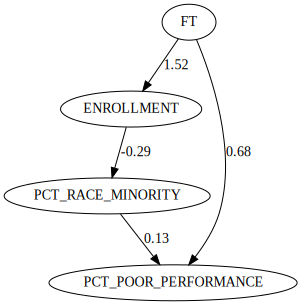

In [ ]:
from causallearn.search.FCMBased import lingam
model = lingam.ICALiNGAM()
model.fit(df)

from causallearn.search.FCMBased.lingam.utils import make_dot
labels = [f'{col}' for i, col in enumerate(df.columns)]
make_dot(model.adjacency_matrix_, labels=labels)

Now we have a DAG and are ready to estimate the causal effects based on that.

## Estimate causal effects using Linear Regression

Now let us see the estimate of causal effect of *mpg* on *weight*.

In [ ]:
# Obtain valid dot format
graph_dot = make_graph(model.adjacency_matrix_, labels=labels)

# Define Causal Model
model=CausalModel(
        data = df,
        treatment='FT',
        outcome='PCT_POOR_PERFORMANCE',
        graph=str_to_dot(graph_dot.source))

# Identification
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

# Estimation
estimate = model.estimate_effect(identified_estimand,
                                method_name="backdoor.linear_regression",
                                control_value=0,
                                treatment_value=1,
                                confidence_intervals=True,
                                test_significance=True)
print("Causal Estimate is " + str(estimate.value))

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                           
─────(E[PCT_POOR_PERFORMANCE])
d[FT]                         
Estimand assumption 1, Unconfoundedness: If U→{FT} and U→PCT_POOR_PERFORMANCE then P(PCT_POOR_PERFORMANCE|FT,,U) = P(PCT_POOR_PERFORMANCE|FT,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

Causal Estimate is 1.071344998100738


In [ ]:
refutation = model.refute_estimate(identified_estimand, estimate, method_name='placebo_treatment_refuter',
                     placebo_type='permute', num_simulations=20)
print(refutation)

             Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.


Refute: Use a Placebo Treatment
Estimated effect:1.071344998100738
New effect:-0.04208441911330594
p value:0.4606182355292562



In [ ]:
covariate_names = ['ENROLLMENT', 'PCT_RACE_MINORITY']  # Replace with actual covariate names

# Iterate over covariates and compute CATE for each
for covariate_name in covariate_names:
    cate_results = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression",
                                        control_value=0,
                                        treatment_value=1,
                                        confidence_intervals=True,
                                        test_significance=True,
                                        method_params={'subset_features': [covariate_name]})

    # Print CATE value for each covariate
    print(f"CATE for {covariate_name} is {cate_results.value}")

CATE for ENROLLMENT is 1.071344998100738
CATE for PCT_RACE_MINORITY is 1.071344998100738


ERROR:dowhy.causal_estimator:No common causes/confounders present. Propensity score based methods are not applicable


Exception: No common causes/confounders present. Propensity score based methods are not applicable

In [ ]:
from scipy import stats
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
from tqdm import tqdm

In [ ]:
# Get estimate (T-Learner)
estimate = model.estimate_effect(
    identified_estimand=identified_estimand,
    method_name='backdoor.econml.metalearners.TLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'models': [
                LGBMRegressor(n_estimators=200, max_depth=10),
                LGBMRegressor(n_estimators=200, max_depth=10)
            ]
        },
        'fit_params': {}
    })

/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

ValueError: Expected 2D array, got scalar array instead:
array=None.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.